# Speech Emotion Recognition (SER) using CNNs and CRNNs Based on Mel Spectrograms and Mel Frequency Cepstral Coefficients (MFCCs).

As humans, recognizing emotions in people is something that depends on body language, facial expressions, and tone of voice. But what if we could recognize emotions in people using a short audio file of their voice? This is what we will try to do in this project.

Recognizing emotions from voice alone is a challenging task. It is not easy for humans to do it, and it is even harder for machines. One reason is that emotions are subjective and not universal. Another reason is that we most often rely on facial expressions and body language to recognize emotions, so relying on voice alone is difficult.

We will be using four datasets in this project:
* [RAVDESS](https://zenodo.org/record/1188976#.X2Q4Z2gzZPY)
* [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
* [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/)
* [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)

We will also be using three different models to classify emotions:
* A Convolutional Neural Network (CNN) trained on the Mel Spectrograms of the audio files.
* A CNN trained on the Mel Frequency Cepstral Coefficients (MFCCs) of the audio files.
* A Convolutional Recurrent Neural Network (CRNN) trained on the Mel Frequency Cepstral Coefficients of the audio files.

Table of Contents:
* [1. Data Collection](#1--data-collection)
* [2. Data Wrangling](#2--data-wrangling)
* [3. Data Exploration, Preparation, and Visualization](#3--data-exploration-preparation-and-visualization)
* [4. Data Preprocessing](#4--data-preprocessing)
* [5.1 Mel Spectrogram CNN Model](#51--mel-spectrogram-cnn-model)
* [5.2 MFCCs CNN Model](#52--mfccs-cnn-model)
* [5.3 MFCCs CRNN Model](#53--mfccs-crnn-model)

## 1- Data Collection

We will be using the kaggle api to automate the process of downloading the datasets. The datasets will each be unzipped to a separate folder.

In [1]:
# Collect CREMA-D audio dataset from Kaggle into a folder called 'cremad'
#!kaggle datasets download -d ejlok1/cremad --unzip -p cremad

In [2]:
# Collect RAVDESS audio dataset from Kaggle into a folder called 'ravdess'
#!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio --unzip -p ravdess

In [3]:
# Collect TESS audio dataset from Kaggle
#!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess --unzip

In [4]:
# Collect SAVEE audio dataset from Kaggle into a folder called 'savee'
#!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee --unzip -p savee

## 2- Data Wrangling

Each of the datasets has a different way of naming the audio files and their labels. Each dataset also has different emotions. So, we will have to do some wrangling to get them all in the same format.

In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
# This allows normalization for the specgrams which allows for clearer visualizations
from matplotlib.colors import Normalize
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
# Set style and color palette
sns.set(style='darkgrid', palette='magma')
# Change the setting and put it in a dictionary
plot_settings = {
    'font.family': 'calibri',
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'figure.dpi': 140,
    'axes.titlepad': 15,
    'axes.labelpad': 15,
    'figure.titlesize': 24,
    'figure.titleweight': 'bold',
}
# Use the dictionary variable to update the settings using matplotlib
plt.rcParams.update(plot_settings)

In [6]:
# Check if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Put the cremad directory in a list
speech = os.listdir('C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/')
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the files and extract the emotion label and path
for dir in speech:
    # Loop through all the files in each directory
    for file in os.listdir('C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/' + dir):
        # Extract the emotion label from the file name
        print(file)
        parts = file.split("-")
        if parts[1] == '0':
            emotion = 'air_conditioner'
        elif parts[1] == '1':
            emotion = 'car_horn'
        elif parts[1] == '2':
            emotion = 'children_playing'
        elif parts[1] == '3':
            emotion = 'dog_bark'
        elif parts[1] == '4':
            emotion = 'drilling'
        elif parts[1] == '5':
            emotion = 'engine_idling'
        elif parts[1] == '6':
            emotion = 'gun_shot'
        elif parts[1] == '7':
            emotion = 'jackhammer'
        elif parts[1] == '8':
            emotion = 'siren'
        elif parts[1] == '9':
            emotion = 'street_music'
        else:
            emotion = 'Unknown'
        # Extract the path
        path = 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/' + dir + '/' + file
        # Append the emotion and path to their lists
        emotions.append(emotion)
        paths.append(path)
# Create a dataframe from the lists
speech_df = pd.DataFrame(emotions, columns=['Emotion'])
speech_df['Path'] = paths
# Inspect the dataframe
speech_df.head()

101415-3-0-2.wav
101415-3-0-3.wav
101415-3-0-8.wav
102106-3-0-0.wav
102305-6-0-0.wav
102842-3-0-1.wav
102842-3-1-0.wav
102842-3-1-5.wav
102842-3-1-6.wav
103074-7-0-0.wav
103074-7-0-1.wav
103074-7-0-2.wav
103074-7-1-0.wav
103074-7-1-1.wav
103074-7-1-2.wav
103074-7-1-3.wav
103074-7-1-4.wav
103074-7-1-5.wav
103074-7-1-6.wav
103074-7-2-0.wav
103074-7-3-0.wav
103074-7-3-1.wav
103074-7-3-2.wav
103074-7-3-3.wav
103074-7-4-0.wav
103074-7-4-1.wav
103074-7-4-2.wav
103074-7-4-3.wav
103074-7-4-4.wav
103074-7-4-5.wav
103074-7-4-6.wav
103258-5-0-0.wav
103258-5-0-1.wav
103258-5-0-10.wav
103258-5-0-11.wav
103258-5-0-12.wav
103258-5-0-13.wav
103258-5-0-14.wav
103258-5-0-15.wav
103258-5-0-16.wav
103258-5-0-17.wav
103258-5-0-18.wav
103258-5-0-19.wav
103258-5-0-2.wav
103258-5-0-3.wav
103258-5-0-4.wav
103258-5-0-5.wav
103258-5-0-6.wav
103258-5-0-7.wav
103258-5-0-8.wav
103258-5-0-9.wav
105415-2-0-1.wav
105415-2-0-15.wav
105415-2-0-19.wav
105415-2-0-21.wav
105415-2-0-24.wav
105415-2-0-4.wav
105415-2-0-6.wav


,Emotion,Path
0,dog_bark,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
1,dog_bark,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
2,dog_bark,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
3,dog_bark,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
4,gun_shot,C:/Users/paihui/Downloads/Compressed/UrbanSoun...


In [8]:
# Put the cremad directory in a list
other_data = os.listdir('C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/other_dataset/')
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the files and extract the emotion label and path
for dir in other_data:
    # Loop through all the files in each directory
    for file in os.listdir('C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/other_dataset/' + dir):
        # Extract the emotion label from the file name
        if dir == 'explosion':
            emotion = 'explosion'
        elif dir == 'scream':
            emotion = 'scream'
        elif dir == 'xiaoai':
            emotion = 'xiaoai'
        else:
            emotion = 'Unknown'
        # Extract the path
        path = 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8k/other_dataset/' + dir + '/' + file
        # Append the emotion and path to their lists
        emotions.append(emotion)
        paths.append(path)
# Create a dataframe from the lists
other_df = pd.DataFrame(emotions, columns=['Emotion'])
other_df['Path'] = paths
# Inspect the dataframe
other_df.head()

,Emotion,Path
0,explosion,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
1,explosion,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
2,explosion,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
3,explosion,C:/Users/paihui/Downloads/Compressed/UrbanSoun...
4,explosion,C:/Users/paihui/Downloads/Compressed/UrbanSoun...


# 3- Data Exploration, Preparation, and Visualization 

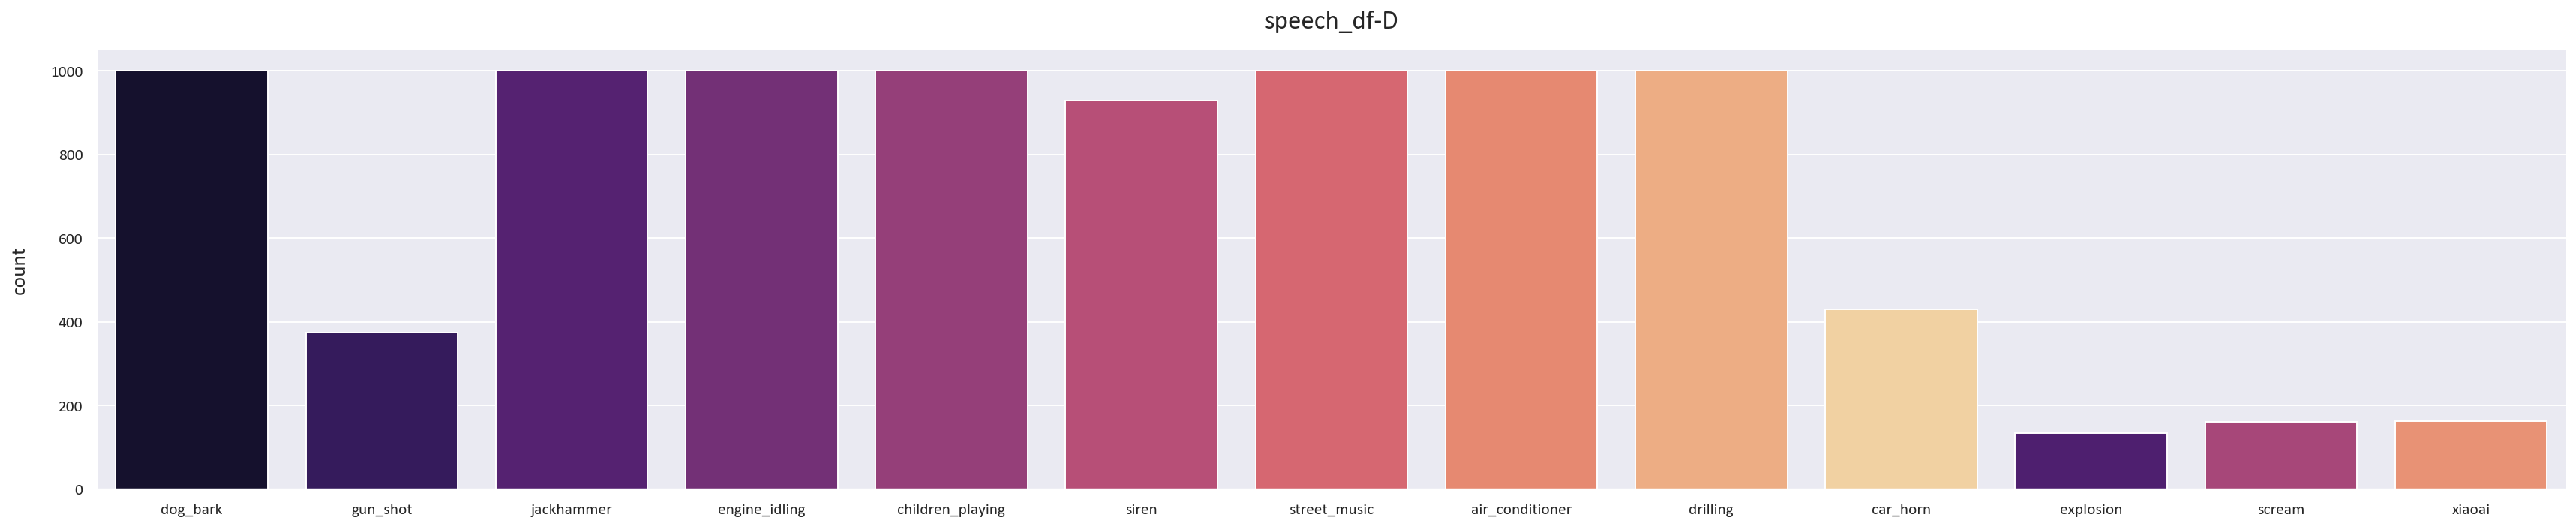

In [9]:
# Plot the value counts for each emotion in each dataset
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
sns.countplot(speech_df, x = speech_df['Emotion'], palette='magma')
plt.title('speech_df-D')
plt.xlabel('')
plt.subplot(2, 1, 1)
sns.countplot(other_df, x = other_df['Emotion'], palette='magma')
plt.title('speech_df-D')
plt.xlabel('')
# Adjust the layout so there are no overlapping titles
plt.tight_layout(pad=2)
# Remove the spines
sns.despine()
plt.show()

In [10]:
# Count the number of emotions in each dataset
print('speech_df-D Emotion Counts:')
print(speech_df['Emotion'].value_counts())
print(other_df['Emotion'].value_counts())


speech_df-D Emotion Counts:
dog_bark            1000
jackhammer          1000
engine_idling       1000
children_playing    1000
street_music        1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: Emotion, dtype: int64
xiaoai       162
scream       161
explosion    133
Name: Emotion, dtype: int64


As we can see, the datasets are not balanced. The Crema-D dataset has the most number of audio files, and the savee dataset has the least. We will have to balance the datasets before training our models. Fortunately, combining the datasets will give us an adequately balanced dataset.

In [11]:

# Combine the two dataframes
df = pd.concat([speech_df, other_df], axis=0)
# Reset the index
df = df.reset_index(drop=True)
# Inspect the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9188 entries, 0 to 9187
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  9188 non-null   object
 1   Path     9188 non-null   object
dtypes: object(2)
memory usage: 143.7+ KB


In [12]:
# Count the number of emotions in the combined dataframe
df['Emotion'].value_counts()

dog_bark            1000
jackhammer          1000
engine_idling       1000
children_playing    1000
street_music        1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
xiaoai               162
scream               161
explosion            133
Name: Emotion, dtype: int64

As expected, the complete dataset is adequately balanced except for the calm, surprise, and neutral emotions. As for the calm emotion, it is extremely similar to the neutral emotion, so we will drop it. Neutral is similar in count to the other emotions, so we will keep it. Surprise would be the only unbalanced emotion, but we will keep it as well, as it is an important emotion to recognize.

In [13]:
# Drop the calm emotion as there are too few samples and it is too similar to neutral
df = df[df['Emotion'] != 'Unknown']

In [14]:
# Check if it was dropped
df = df.reset_index(drop=True)
df['Emotion'].value_counts()


dog_bark            1000
jackhammer          1000
engine_idling       1000
children_playing    1000
street_music        1000
air_conditioner     1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
xiaoai               162
scream               161
explosion            133
Name: Emotion, dtype: int64

['C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold10/167464-0-0-8.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold4/174841-1-0-0.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold1/192124-2-0-7.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold9/152588-3-3-0.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold9/58937-4-0-0.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-14.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8k/other_dataset/explosion/45.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold2/163460-6-0-0.wav', 'C:/Users/paihui/Downloads/Compressed/UrbanSound8K/UrbanSound8K/UrbanSound8K/audio/fold4/132016-7-0-1.wav', 'C:/Users/paihui/Downloads/Compressed

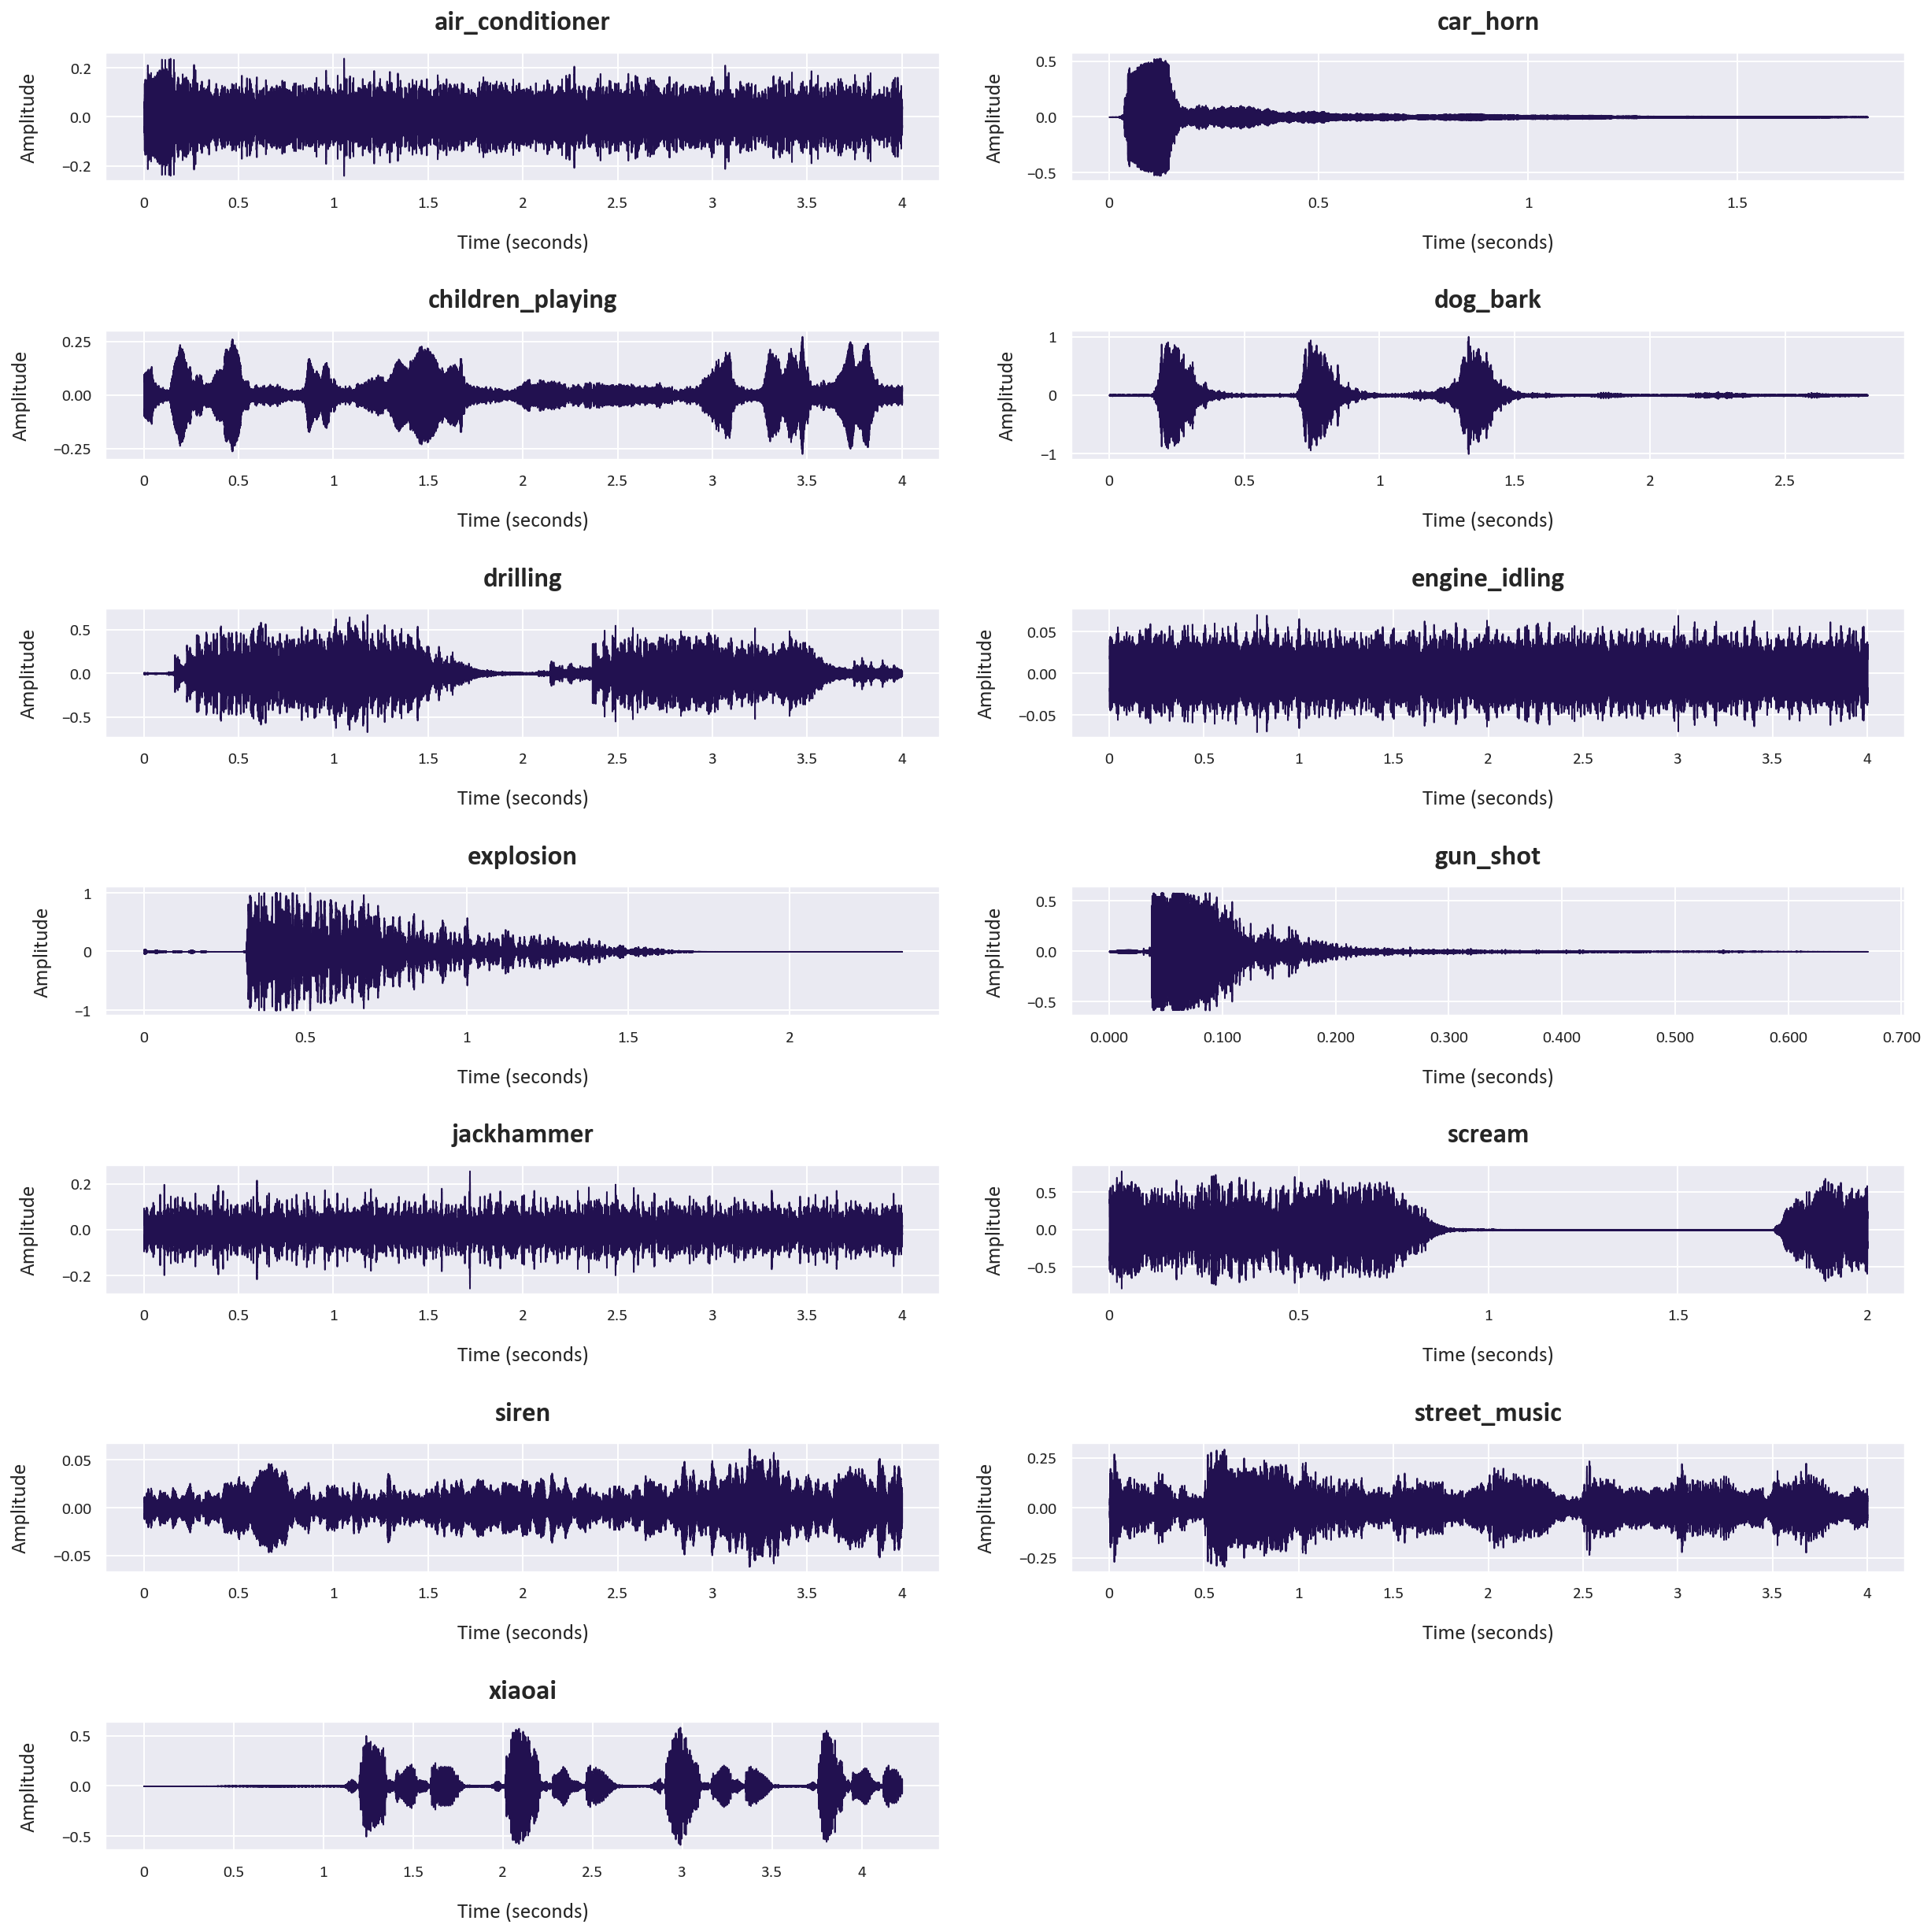

In [15]:
# Get a sample from each emotion type
sample = df.groupby('Emotion', group_keys=False).apply(lambda x: x.sample(1))
# extract the path from the sample
sample_paths = sample['Path'].tolist()
print(sample_paths)
# Create a waveform plot for a sample of each emotion
plt.figure(figsize=(18, 18))
for i in range(13):
    plt.subplot(7, 2, i+1)
    # Load the audio file and set the sampling rate to 44100
    data, sr = librosa.load(sample_paths[i], sr = 44100)
    # Plot the waveform
    librosa.display.waveshow(data, sr=sr)
    # Add a title and make it bold
    plt.title(sample['Emotion'].values[i], fontweight='bold')
    # Add labels to the x and y axes
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
# Adjust the layout so there are no overlapping titles
plt.tight_layout(pad=2)

Mel Spectrograms are a visual representation of the spectrum of frequencies of a signal as it varies with time. They are commonly used in speech recognition. We will be using them as input to our CNN model.

They are generated by applying the Short Time Fourier Transform (STFT) to a signal. The STFT is applied to a signal by applying the Fourier Transform to small overlapping windows of the signal.

The Mel Spectrogram is then generated by mapping the power of the signal obtained from the STFT to the mel scale. The mel scale is a scale that relates the perceived frequency of a tone to the actual measured frequency.

The mel scale is logarithmic, so it is more similar to the human auditory system than the linear frequency scale.

The brightness of the spectrogram represents the loudness in decibels of the frequencies at a given time. The y-axis represents the frequencies, and the x-axis represents the time.

This [article](https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505#:~:text=A%20Mel%20Spectrogram%20makes%20two,of%20Amplitude%20to%20indicate%20colors.) explains the process of generating Mel Spectrograms in more detail


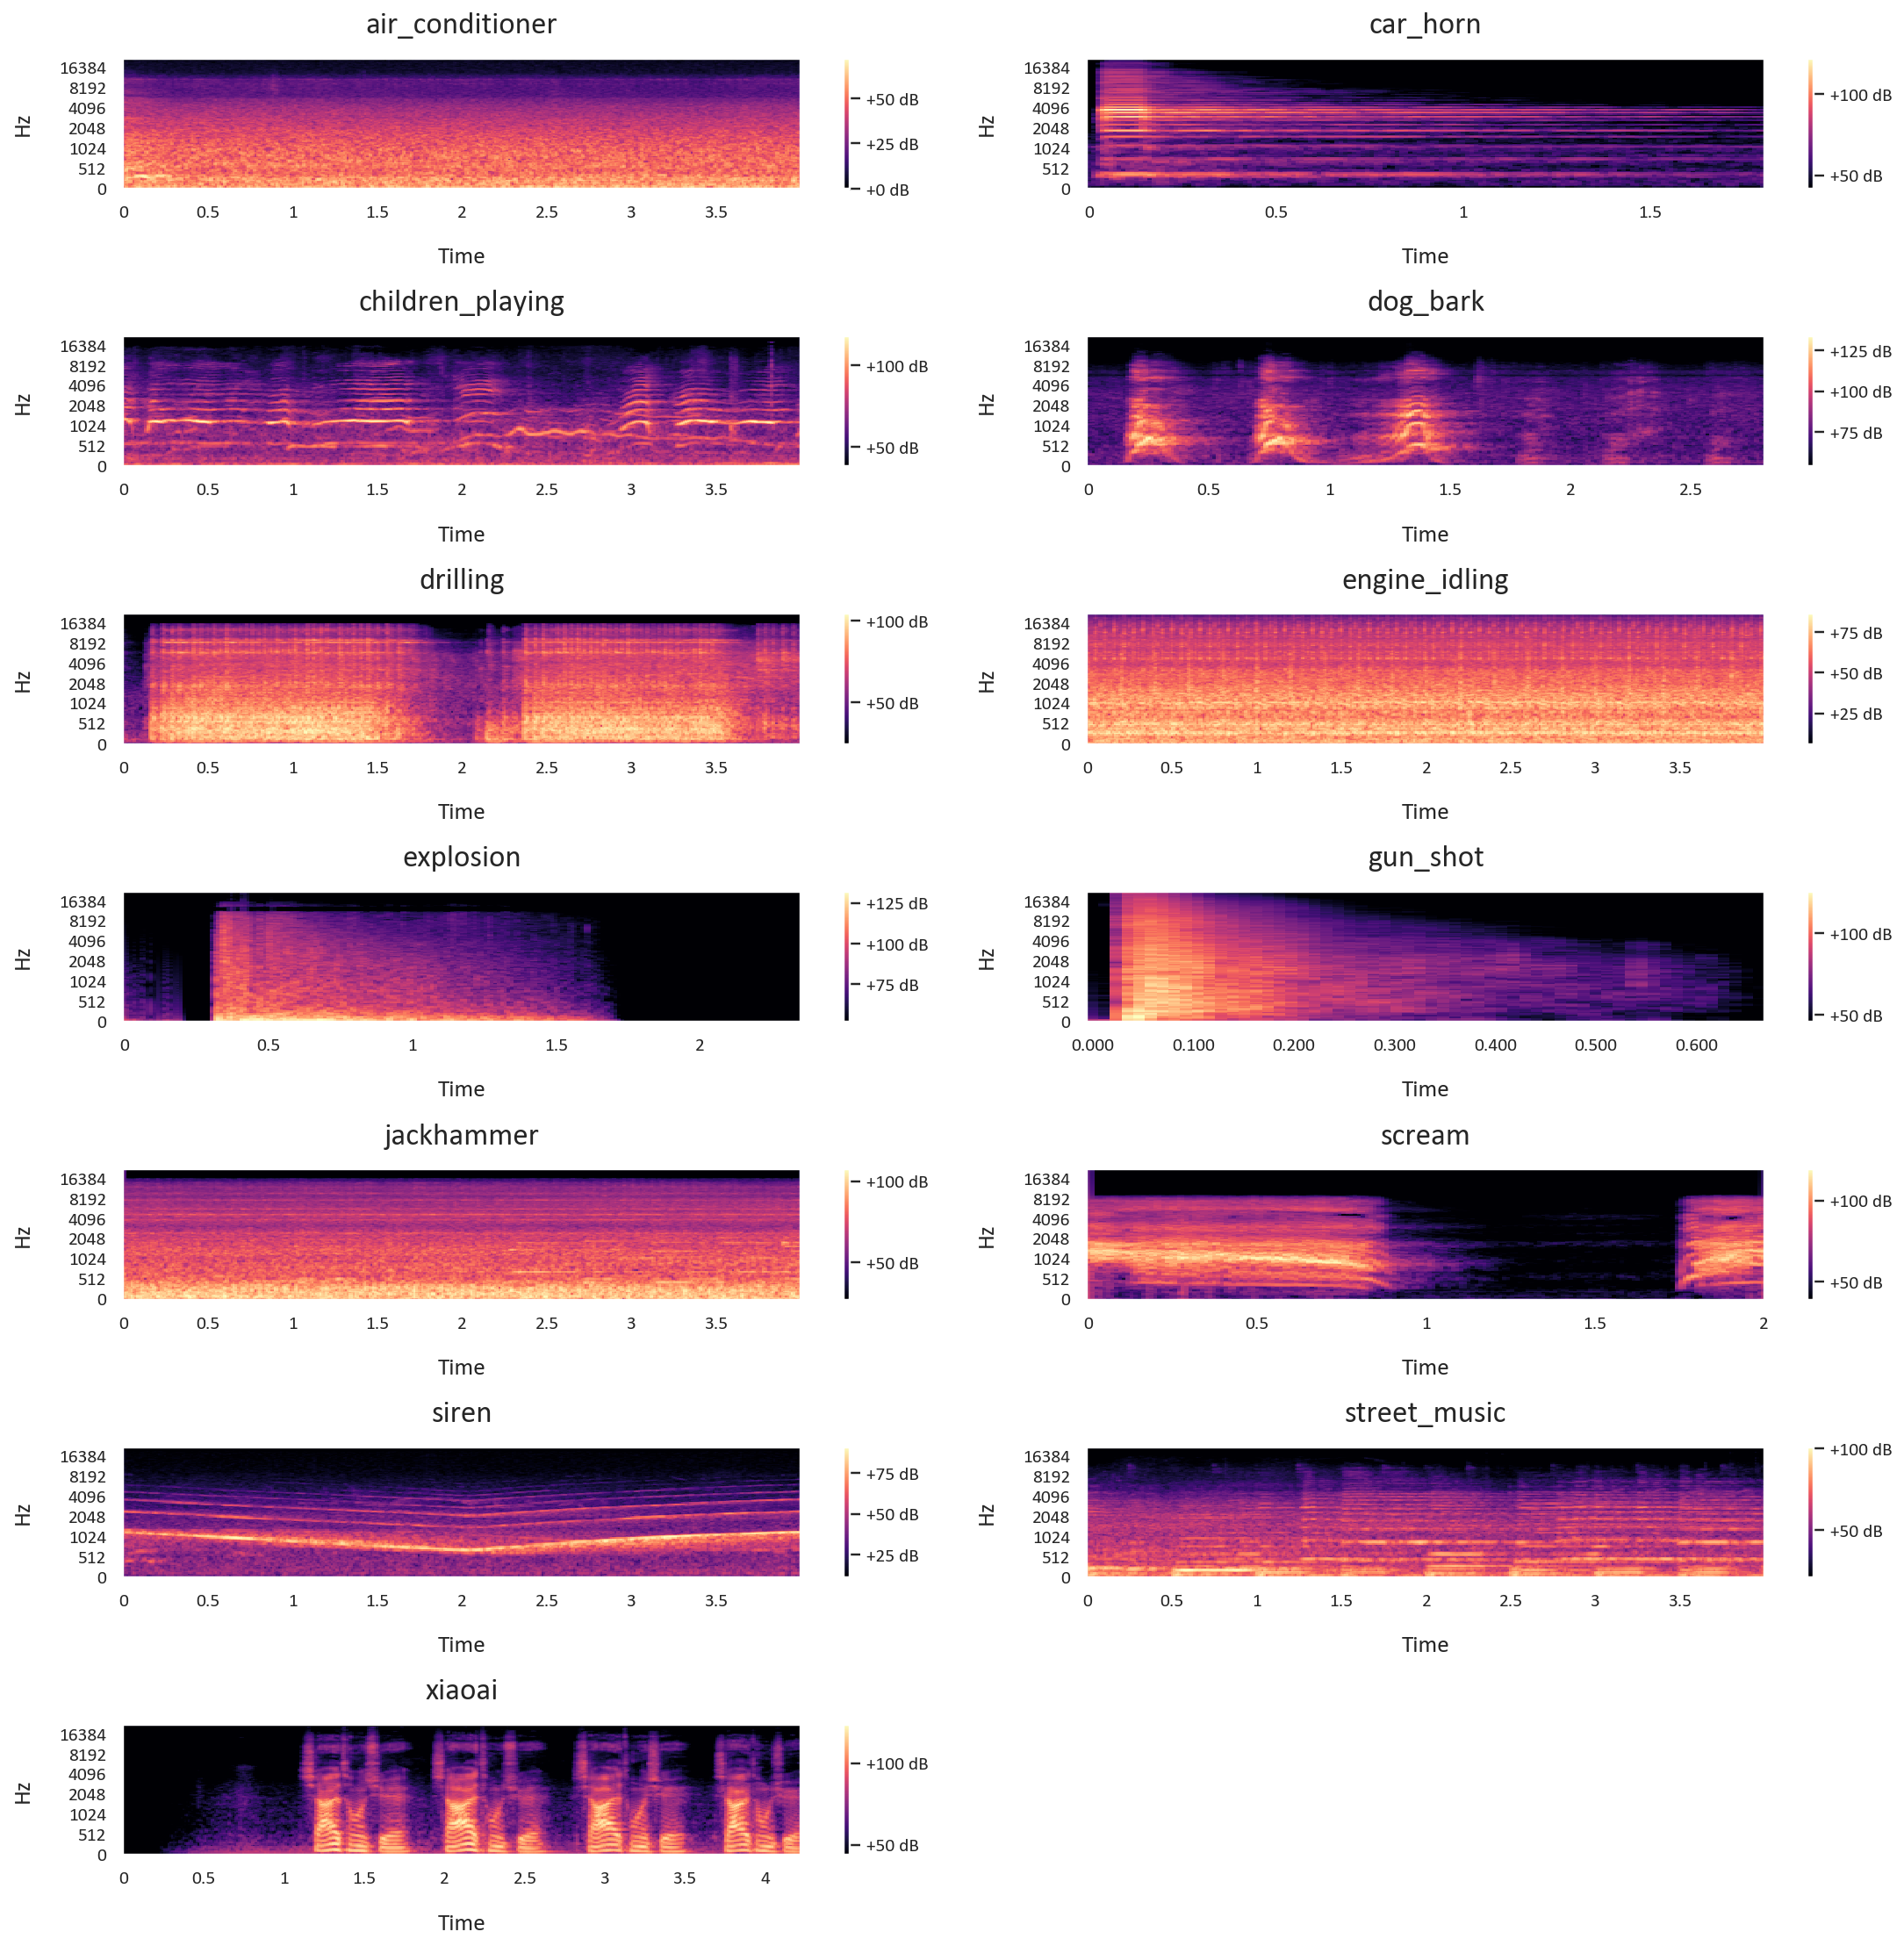

In [17]:
# Create a spectrogram plot for each emotion
plt.figure(figsize=(16, 16))
for i in range(13):
    plt.subplot(7, 2, i+1)
    # Load the audio file, we chose sr = 44100 to standardize the sampling rate
    signal, sr = librosa.load(sample_paths[i], sr=44100)
    # Make the logarithmically scaled mel spectrogram
    signal = librosa.feature.melspectrogram(y = signal, sr=sr)
    # Convert the spectrogram from amplitude squared to decibels
    # as amplitude does not give us much information
    signal = librosa.power_to_db(signal, ref=np.min)
    # Plot the spectrogram
    librosa.display.specshow(signal, sr=sr, x_axis='time', y_axis='mel')
    plt.title(sample['Emotion'].values[i])
    # Plot a color bar to show the intensity scale from 0 Decibels to the max
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
    

## 4- Data Preprocessing

We will be using the librosa library to extract the Mel Spectrograms from the audio files. We will also be using the sklearn library to split the data into training and testing sets.

In [18]:
# Encode the emotion labels into numbers 
encoder = LabelEncoder()
df['Emotion'] = encoder.fit_transform(df['Emotion'])
# Make sure the encoding worked
df['Emotion'].value_counts()

3     1000
8     1000
5     1000
2     1000
11    1000
0     1000
4     1000
10     929
1      429
7      374
12     162
9      161
6      133
Name: Emotion, dtype: int64

We should standardize the data by making the mean 0 and standard deviation 1 before feeding it to the model. This will help the model train faster and generalize better. 

Next, we make a Dataset object from the data. This will allow us to make batches, and prefetch the data, which means that the data will be loaded to the GPU while the model is training on the previous batch. This will make the training process faster.

## 5- Modeling

### 5.1- Mel Spectrogram CNN Model
We will treat the mel spectrograms as images and use a CNN to classify them. We will use the Adam optimizer and the sparse categorical cross entropy loss function.

In [19]:
# Create a callback that stops training when the validation loss plateaus or increases
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode = 'min')

In [20]:
# Create a callback that adjusts the learning rate gradually
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=0.000001,
                                                    patience=3,
                                                    mode='min')

As we can see, the model plateaus at around 70% validation accuracy. This is a great accuracy for such a complex task, as it is hard for even a human to recognize a very specific emotion from an audio file 2-4 seconds long.

Another metric that we can use is MFCCs, or Mel Frequency Cepstral Coefficients, which extracts features from the audio files. This is a common technique used in speech recognition, and it is known to work well. Let's see if it can improve our validation accuracy and loss.

MFCCs are generated by applying the Discrete Cosine Transform (DCT) to the Mel Spectrogram. The DCT is similar to the Fourier Transform, but it only uses real numbers. The DCT is applied to the Mel Spectrogram by applying it to each frequency bin of the Mel Spectrogram. The result is a set of coefficients that represent the power of the signal in each frequency bin.

MFCCs are commonly used in speech recognition because they are a good representation of the vocal tract and the vocal tract shape.

This makes MFCCs the state of the art technique for speech recognition. We used 128 MFCCs to make it more similar to the Mel Spectrograms and less prone to overfitting. However, we could have used fewer MFCCs, as the first 20-30 MFCCs are the most important.

This [review](https://ieeexplore.ieee.org/abstract/document/9955539) explains MFCCs and its performance in many applications in more detail.

We will also treat the MFCCs as images and use a CNN to classify them.

In [21]:
# Create a function that extracts MFCCs from an audio file
def extract_mfcc(path):
    ''' 
    Load the audio file, convert the audio file into MFCCs and return the MFCCs
    '''
    # 加载音频，不限制持续时间
    audio, sr = librosa.load(path, sr=44100, mono=True)
    #响度标准化
    audio, _ = librosa.effects.trim(audio)
    audio = librosa.util.normalize(audio)
    # 对于少于4秒的音频文件，在末尾用零填充
    if len(audio) <= 2 * sr:
        audio = np.pad(audio, pad_width=(0, 2 * sr - len(audio)), mode='constant')
    else :
        # 截断音频
        audio = audio[:2 * sr]
    signal = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=80)
    # print(signal.shape)
    # Return the MFCCs as a numpy array
    return np.array(signal)

MFCC shape: (80, 173)


Text(0.5, 1.0, 'MFCC')

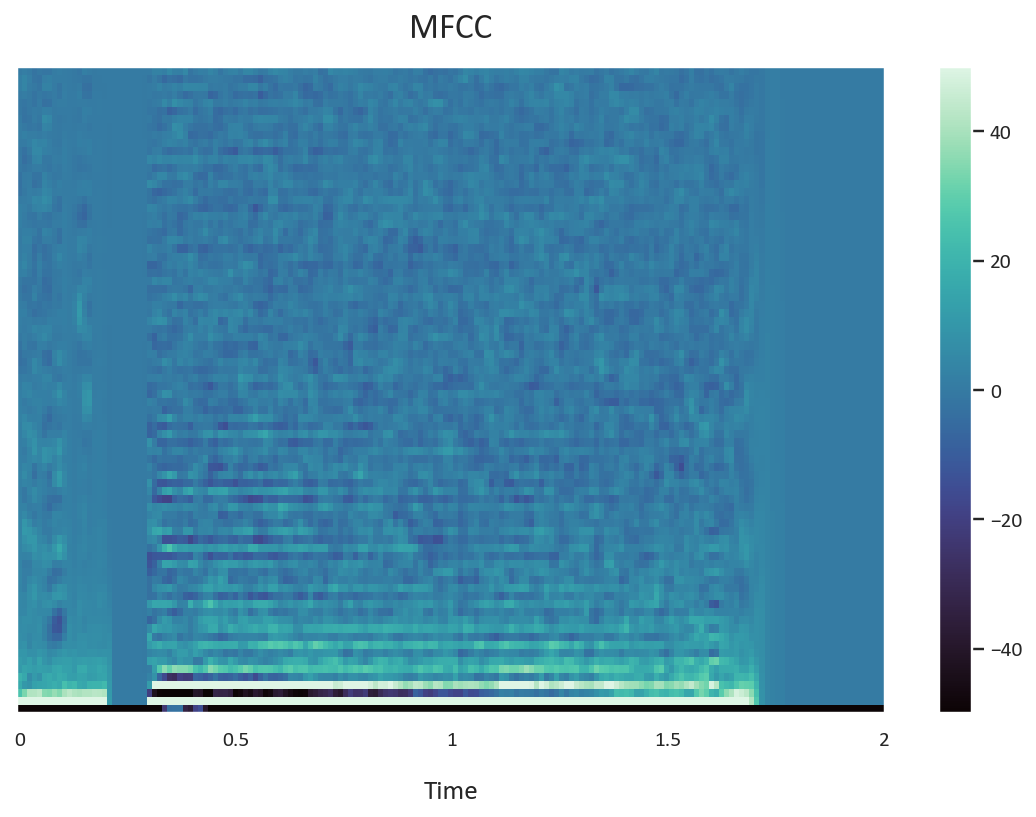

In [22]:
# Test the function on the sample audio file
mfcc = extract_mfcc(sample_paths[6])
print('MFCC shape:', mfcc.shape)
# Plot the MFCC
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'mako', norm = Normalize( vmin = -50, vmax = 50))
plt.colorbar()
plt.title('MFCC')

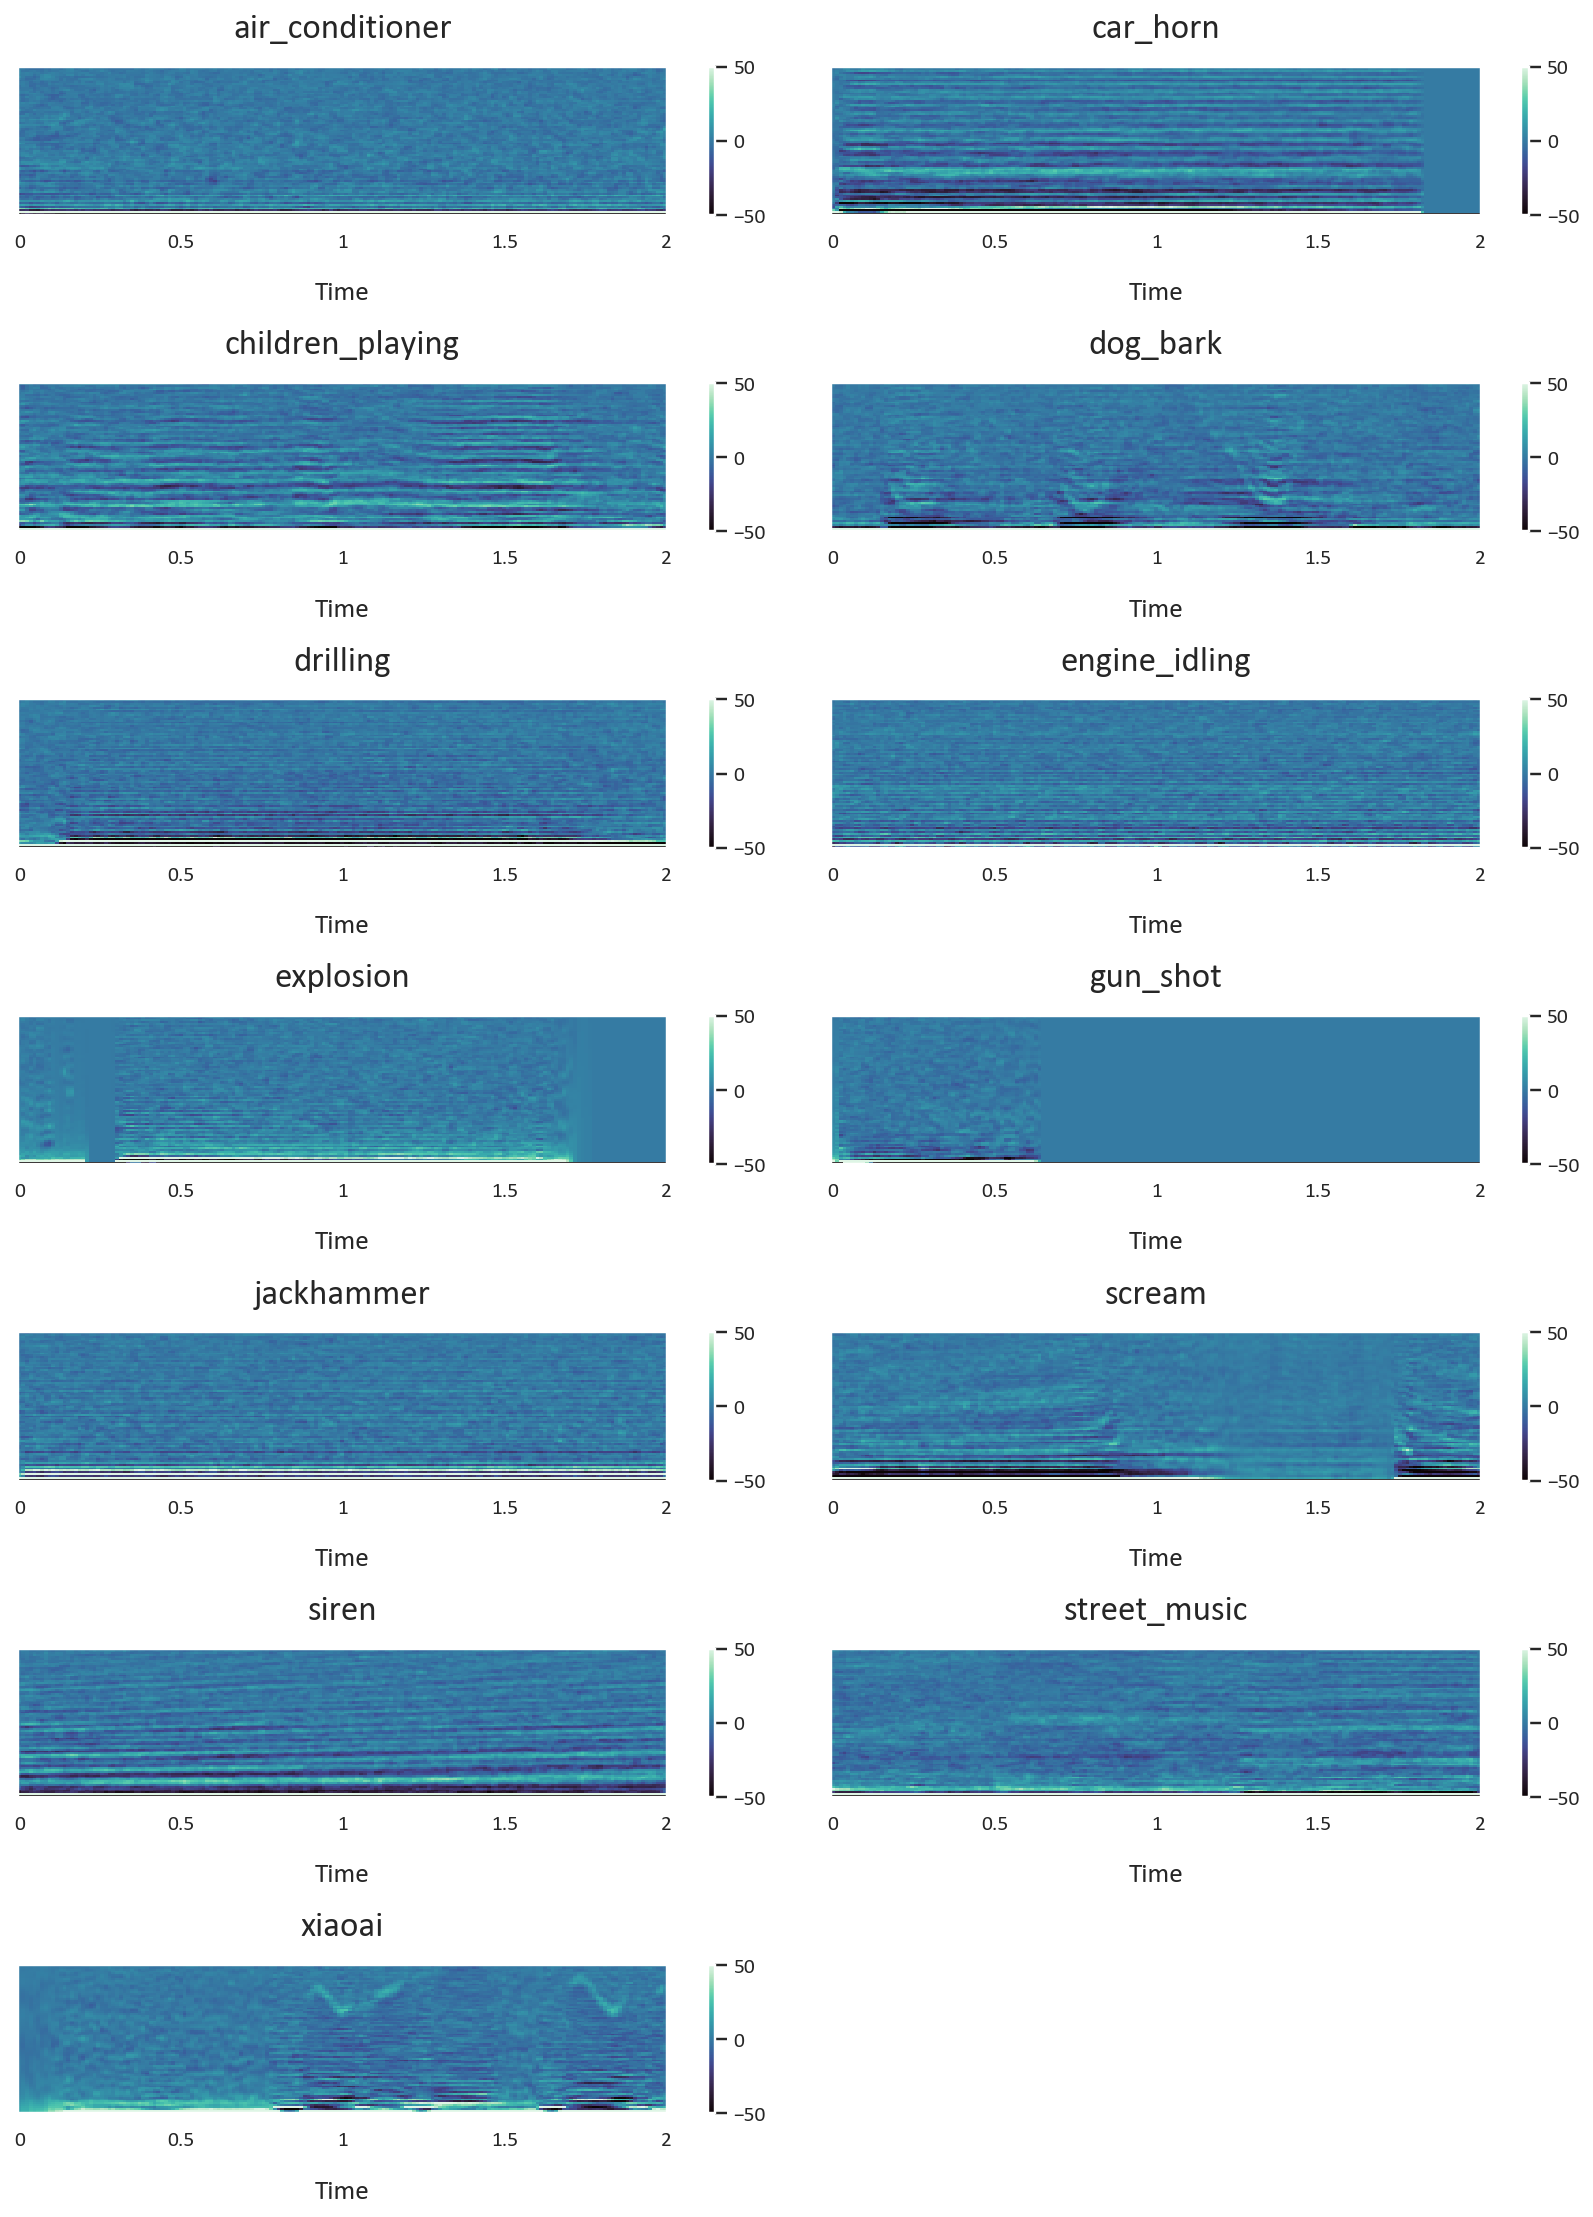

In [23]:
# Visualize the MFCCs for each emotion
plt.figure(figsize=(12, 16))
for i in range(13):
    plt.subplot(7, 2, i+1)
    # Extract the MFCCs from the audio file
    mfcc = extract_mfcc(sample_paths[i])
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'mako', norm = Normalize( vmin = -50, vmax = 50))
    plt.title(sample['Emotion'].values[i])
    plt.colorbar()
plt.tight_layout()

In [24]:
from tqdm import tqdm

# Divide the data into features and labels
X_mfcc = [extract_mfcc(path) for path in tqdm(df['Path'], desc="Extracting MFCC")]
y_mfcc = df['Emotion']

Extracting MFCC: 100%|██████████| 9188/9188 [07:38<00:00, 20.03it/s]


In [26]:
# Divide the data into training and testing sets, with a 80:20 split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_mfcc, y_mfcc,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle=True)
# 然后，从X_train和y_train中分割出验证集（大约10%的总数据量）
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_2, y_train_2, test_size=0.1, random_state=0, shuffle=True)

In [27]:
# Check the length of the training and testing sets
print('Number of training images:', len(X_train_final))
print('Number of testing images:', len(X_test_2))
print('Number of validation images:', len(X_val))
# Check the length of the training and testing labels
print('Number of training labels:', len(y_train_final))
print('Number of testing labels:', len(y_test_2))
print('Number of validation labels:', len(y_val))

Number of training images: 6615
Number of testing images: 1838
Number of validation images: 735
Number of training labels: 6615
Number of testing labels: 1838
Number of validation labels: 735


In [28]:
# Convert the lists into numpy arrays
X_train_2 = np.array(X_train_final)
X_test_2 = np.array(X_test_2)
y_train_2 = np.array(y_train_final)
y_test_2 = np.array(y_test_2)
X_val = np.array(X_val)
y_val = np.array(y_val)
# Check the shape of the arrays
print('X_train shape:', X_train_2.shape)
print('X_test shape:', X_test_2.shape)
print('y_train shape:', y_train_2.shape)
print('y_test shape:', y_test_2.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (6615, 80, 173)
X_test shape: (1838, 80, 173)
y_train shape: (6615,)
y_test shape: (1838,)
X_val shape: (735, 80, 173)
y_val shape: (735,)


In [29]:
# Standardize the data by subtracting the mean and dividing by the standard deviation
mean = np.mean(X_train_2)
std = np.std(X_train_2)
X_train_2 = (X_train_2 - mean) / std
X_test_2 = (X_test_2 - mean) / std
X_val = (X_val - mean) / std

In [30]:
# Check the mean and standard deviation
print('Mean:', mean)
print('Standard deviation:', std)
# Check if the data is standardized
print('Mean of standardized data:', np.mean(X_train_2))
print('Standard deviation of standardized data:', np.std(X_train_2))

Mean: -0.7870202
Standard deviation: 32.789604
Mean of standardized data: -5.4595677e-08
Standard deviation of standardized data: 0.99999934


In [31]:
# Reshape the data into 4D arrays so that it can be input into the 2D CNN
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 80, 173, 1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 80, 173, 1)
X_val = X_val.reshape(X_val.shape[0], 80, 173, 1)
# Check the shape of the arrays
print('X_train shape:', X_train_2.shape)
print('X_test shape:', X_test_2.shape)
print('X_val shape:', X_val.shape)

X_train shape: (6615, 80, 173, 1)
X_test shape: (1838, 80, 173, 1)
X_val shape: (735, 80, 173, 1)


In [36]:
# Divide the data into batches of 32 images
batch_size = 16
tf.keras.backend.clear_session()
# Make a training dataset from the training set
train_dataset_2 = tf.data.Dataset.from_tensor_slices((X_train_2, y_train_2))
# Shuffle, batch, and prefetch the data
train_dataset_2 = train_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# Make a testing dataset from the testing set
test_dataset_2 = tf.data.Dataset.from_tensor_slices((X_test_2, y_test_2))
# Shuffle, batch, and prefetch the data
test_dataset_2 = test_dataset_2.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### 5.2- MFCCs CNN Model

In [37]:
# Define the CNN model
model_mfcc = tf.keras.Sequential([
    # First convolutional layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(80, 173, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Batch normalization maintains the 0 mean and 1 standard deviation
    tf.keras.layers.BatchNormalization(),
    # Second convolutional layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Third convolutional layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Fourth convolutional layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    # Global average pooling layer averages the values in each feature map into
    # a single value and flattens the result into a (none, 256) array
    tf.keras.layers.GlobalAveragePooling2D(),
    # Dropout layer randomly sets 50% of the activations to zero
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [38]:
# Compile the model
model_mfcc.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# fit the model
history_mfcc = model_mfcc.fit(train_dataset_2,
                    epochs=150,
                    validation_data=test_dataset_2,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/150
414/414 [==============================] - 6s 14ms/step - loss: 1.3164 - accuracy: 0.5664 - val_loss: 2.8016 - val_accuracy: 0.2269 - lr: 0.0010
Epoch 2/150
414/414 [==============================] - 5s 13ms/step - loss: 0.8791 - accuracy: 0.7205 - val_loss: 1.0607 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 3/150
414/414 [==============================] - 5s 13ms/step - loss: 0.6892 - accuracy: 0.7800 - val_loss: 0.7823 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 4/150
414/414 [==============================] - 5s 13ms/step - loss: 0.5548 - accuracy: 0.8254 - val_loss: 0.9815 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 5/150
414/414 [==============================] - 5s 13ms/step - loss: 0.4639 - accuracy: 0.8525 - val_loss: 0.6993 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 6/150
414/414 [==============================] - 5s 13ms/step - loss: 0.3923 - accuracy: 0.8771 - val_loss: 0.5858 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 7/150
414/414 [==============================] - 5s 

In [40]:
# Save the model
model_mfcc.save('sound_classification_sound8k_xiaoai.keras')

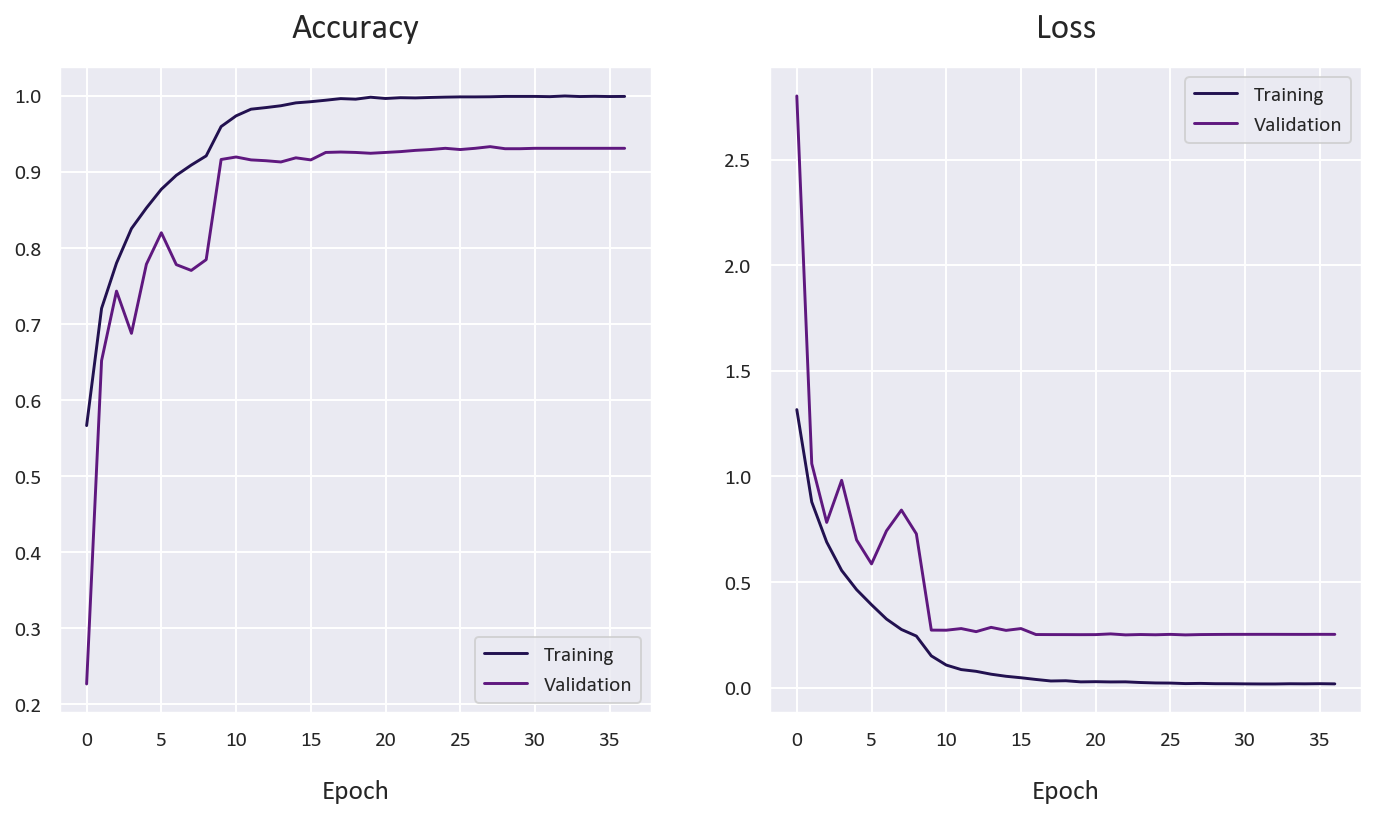

In [41]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_mfcc.history['accuracy'], label='Training')
plt.plot(history_mfcc.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_mfcc.history['loss'], label='Training')
plt.plot(history_mfcc.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

In [42]:
# 用上面预留的40%测试集评估模型
# tf.keras.backend.clear_session()
# X_mfcc_remaining = np.array(X_mfcc_remaining)
# y_mfcc_remaining = np.array(y_mfcc_remaining)
# print('X_mfcc_remaining shape:', X_mfcc_remaining.shape)
# print('y_mfcc_remaining shape:', y_mfcc_remaining.shape)
# X_mfcc_remaining = X_mfcc_remaining.reshape(X_mfcc_remaining.shape[0], 128, 345, 1)
# print('X_mfcc_remaining shape:', X_mfcc_remaining.shape)
# print('y_mfcc_remaining shape:', y_mfcc_remaining.shape)
# X_mfcc_remaining = (X_mfcc_remaining - mean) / std
# 模型路径
model_path = 'sound_classification_sound8k_xiaoai.keras'
# 加载模型
model_mel = tf.keras.models.load_model(model_path)
y_pred = model_mfcc.predict(X_val)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Plot the classification report
print(classification_report(y_val, y_pred, target_names=encoder.classes_))

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.97      0.97        73
        car_horn       0.97      1.00      0.98        32
children_playing       0.80      0.87      0.84        79
        dog_bark       0.85      0.87      0.86        84
        drilling       0.97      0.95      0.96        94
   engine_idling       0.95      1.00      0.98        59
       explosion       1.00      1.00      1.00        10
        gun_shot       1.00      0.94      0.97        32
      jackhammer       0.95      0.97      0.96        79
          scream       1.00      1.00      1.00        12
           siren       0.95      0.93      0.94        83
    street_music       0.97      0.86      0.91        86
          xiaoai       1.00      1.00      1.00        12

        accuracy                           0.93       735
       macro avg       0.95      0.95      0.95       735
    weighted avg       0.93      0.93      0.93       735



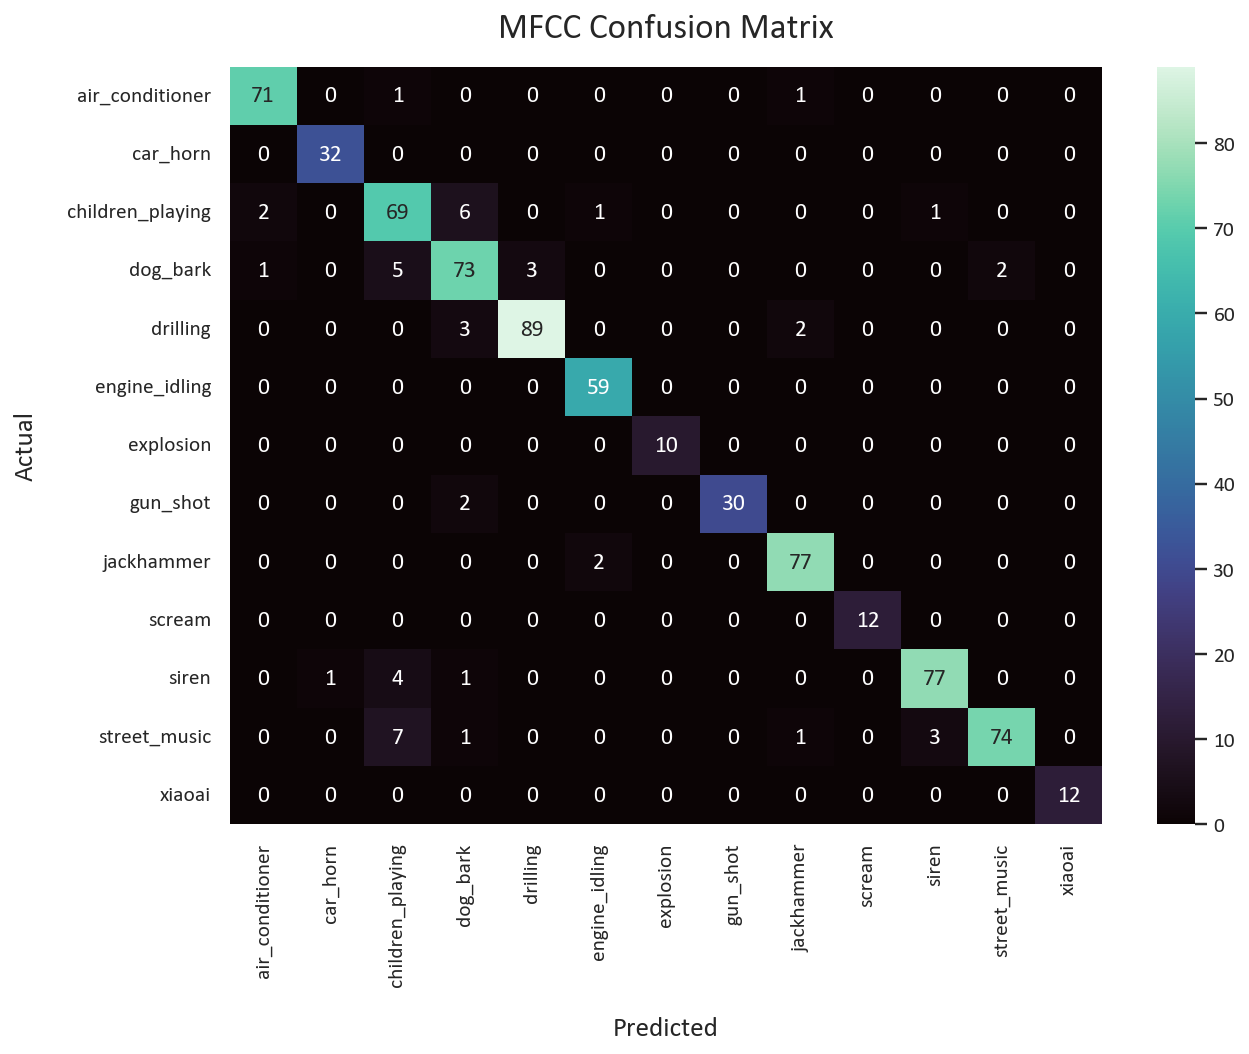

In [43]:
# Plot the confusion matrix for the validation set
# Get the predictions for the test data
y_pred = model_mfcc.predict(X_val)
# Convert the predictions into one-hot encoded vectors
y_pred = np.argmax(y_pred, axis=1)
# Get the confusion matrix
cm = tf.math.confusion_matrix(y_val, y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
# Make the index and column labels the emotion names
cm = pd.DataFrame(cm.numpy(), index=encoder.classes_, columns=encoder.classes_)
sns.heatmap(cm, annot=True, fmt='', cmap='mako')
plt.title('MFCC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout(pad=2)